In [1]:
!nvidia-smi

Sun Oct 22 11:28:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.1 ; cuda:  cu118
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-zyxjbp79
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-zyxjbp79
  Resolved https://github.com/facebookresearch/detectron2.git to commit 898507047cf441a1e4be7a729270961c401c4354
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
%cd /content/drive/MyDrive/Classes/Detectron2

/content/drive/MyDrive/Classes/Detectron2


In [6]:
!pwd

/content/drive/MyDrive/Classes/Detectron2


In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sample", {}, "./data/trainval.json", "./data/images")

In [8]:
sample_metadata = MetadataCatalog.get("sample")
dataset_dicts = DatasetCatalog.get("sample")

[10/22 11:42:42 d2.data.datasets.coco]: Loading ./data/trainval.json takes 2.83 seconds.
WARNING [10/22 11:42:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/22 11:42:42 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json


In [10]:
# dataset_dicts

In [12]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/22 11:48:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 190MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/22 11:48:52 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/22 11:49:14 d2.utils.events]:  eta: 0:03:58  iter: 19  total_loss: 3.808  loss_cls: 2.525  loss_box_reg: 0.607  loss_mask: 0.6893  loss_rpn_cls: 0.03118  loss_rpn_loc: 0.01234    time: 0.9080  last_time: 0.7998  data_time: 0.4728  last_data_time: 0.3482   lr: 0.00016068  max_mem: 2668M
[10/22 11:49:29 d2.utils.events]:  eta: 0:02:36  iter: 39  total_loss: 2.123  loss_cls: 0.9109  loss_box_reg: 0.6129  loss_mask: 0.6404  loss_rpn_cls: 0.01594  loss_rpn_loc: 0.0109    time: 0.7220  last_time: 0.4827  data_time: 0.0676  last_data_time: 0.0072   lr: 0.00032718  max_mem: 2669M
[10/22 11:49:38 d2.utils.events]:  eta: 0:01:58  iter: 59  total_loss: 1.838  loss_cls: 0.69  loss_box_reg: 0.5477  loss_mask: 0.5305  loss_rpn_cls: 0.01873  loss_rpn_loc: 0.008002    time: 0.6444  last_time: 0.4857  data_time: 0.0141  last_data_time: 0.0128   lr: 0.00049367  max_mem: 2669M
[10/22 11:49:48 d2.utils.events]:  eta: 0:01:47  iter: 79  total_loss: 1.766  loss_cls: 0.6153  loss_box_reg: 0.6964  loss_ma

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("sample", )
predictor = DefaultPredictor(cfg)

[10/22 11:54:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [15]:
%pwd

'/content/drive/MyDrive/Classes/Detectron2'

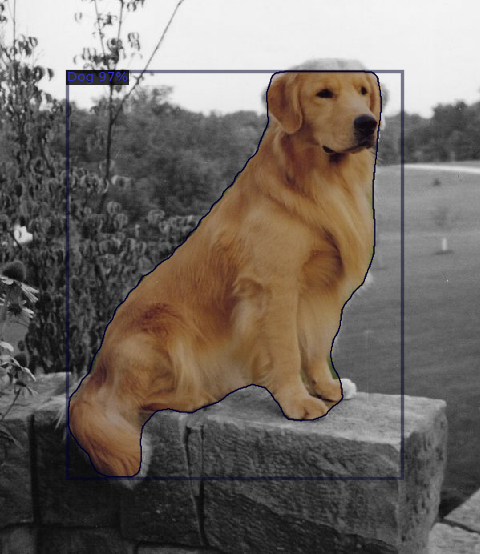

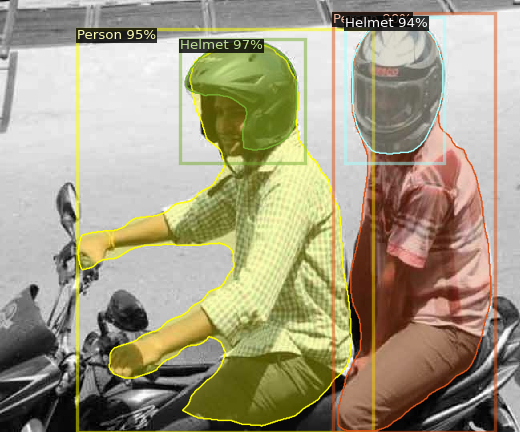

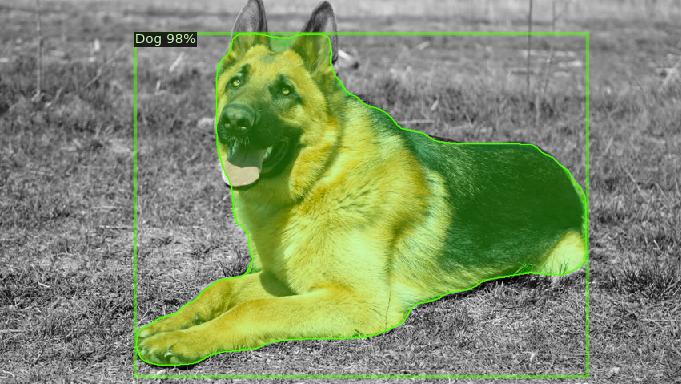

In [16]:
from detectron2.utils.visualizer import ColorMode
import os

data_path = "/content/drive/MyDrive/Classes/Detectron2/test_data/"

for d in os.listdir("test_data"):
    im = cv2.imread(data_path + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

# Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("sample", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "sample")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [08/20 05:25:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 05:25:03 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json
[08/20 05:25:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/20 05:25:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/20 05:25:03 d2.data.common]: Serializing 51 elements to byte tensors and concatenating them all ...
[08/20 05:25:03 d2.data.common]: Serialized dataset takes 0.13 MiB
[08/20 05:25:03 d2.evaluation.evaluator]: Start inference on 51 batches
[08/20 05:25:05 d2.evaluation.evaluator]: Inference done 11/51. Dataloading: 0.0072 s/iter. Inference: 0.1425 s/iter. Eval: 0.0042 s/iter. Total: 0.1540 s/iter. ETA=0:00:06
[08/20 05:25:10 d2.evaluation.evaluator]: Inference

## Getting the custom config file

In [ ]:
pwd

'/content/drive/MyDrive/Classes/Detectron2'

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()